In [47]:
from dotenv import load_dotenv
import mlflow

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

import optuna
import matplotlib.pyplot as plt

import os
import nbformat

import nbimporter

from first_transform import series_to_supervised

# Configuración warnings
# ==============================================================================
import warnings

c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
load_dotenv()

True

In [49]:
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

### Obteniendo datos procesados de la demanda de energía
Se obtiene los datos que han sido procesados anteriormente

In [9]:
data = pd.read_csv('../data/processed/processed_data_energy.csv')

data.head()

,hora,dia,mes,anio,tmax-cab,tmax-hmo,tmax-obr,tmax-lmo,tmax-cul,tmin-cab,...,martes_postfestivo,semana_santa,1_mayo,10_mayo,16_sep,2_nov.,pre-navidad_y_new_year,navidad_y_new_year,post-navidad_y_new_year,demanda_energia
0,0,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1394
1,1,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1297
2,2,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1255
3,3,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1222
4,4,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1168


### Transformando los datos
De la libreta first_transform, importamos previamente la función series_to_supervised (al principio) para poder transformar nuestro dataset en uno que pueda ser procesado por nuestro modelo y listo para trabajar con una serie de tiempo.

In [10]:
supervised_data = series_to_supervised(data[data.columns[4:]], n_in=12, n_out=1)

supervised_data.head()

,tmax-cab(t-12),tmax-hmo(t-12),tmax-obr(t-12),tmax-lmo(t-12),tmax-cul(t-12),tmin-cab(t-12),tmin-hmo(t-12),tmin-obr(t-12),tmin-lmo(t-12),tmin-cul(t-12),...,martes_postfestivo(t),semana_santa(t),1_mayo(t),10_mayo(t),16_sep(t),2_nov.(t),pre-navidad_y_new_year(t),navidad_y_new_year(t),post-navidad_y_new_year(t),demanda_energia(t)
12,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1079
13,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1086
14,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1083
15,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1073
16,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1067


### Separando los datos
En todo estudio predictivo, es importante ajustar el modelo, pero también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer nuestra evaluación, divideremos los datos en dos grupos, uno de entrenamiento y otro de test.

In [11]:
X = supervised_data.drop(columns=['demanda_energia(t)'])
y = supervised_data['demanda_energia(t)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Estandarizando los datos
Una vez separados los datos, podemos proceder a su preprocesamiento con una estandarización, ya que esto puede mejorar el rendimiento del modelo y facilitar la convergencia durante el entrenamiento, el cual en este caso consiste en una simple normalización.

In [12]:
# Inicializando nuestro escalador
# ==============================================================================
scaler = StandardScaler()

# Ajustar el escalador en los datos de entrenamiento y transformar
# ==============================================================================
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Creando y Entrenando el Modelo
Utilizando HistGradientBoostingRegressor, nueva implementación de scikit-learn inspirada en gran medida en LightGBM y es mucho mas rapida que la implementación original de sklearn GradientBoosting

In [13]:
# Creación del modelo
# ==============================================================================
modelo = HistGradientBoostingRegressor(
            max_iter     = 10,
            loss         = 'squared_error',
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train_scaled, y_train)

HistGradientBoostingRegressor(max_iter=10, random_state=123)

### Predicción y evaluación del modelo
Ya que se ha entrenado el modelo, se evalúa la capacidad predictiva empleando el conjunto de test.

In [15]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test_scaled)

# Cálculo del RMSE
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

# Cálculo del MAPE
mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predicciones)
print(f"El error (mape) de test es: {mape}")

El error (rmse) de test es: 286.1551716211704
El error (mape) de test es: 0.10343792718926378


c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


> Para una configuración inicial de nuestros hiperparámetros de nuestro modelo hecho con Gradient Boosting , podemos observar que nos muestra un error cuadrado medio alto, al igual que nuestro mape, no cunple con lo establecido en nuestras metricas, puesto que nos da un valor de 10%, el doble del minimo establecido para considerar bueno nuestro modelo.
Ahora bien aplicaremos una serie de procedimientos para encontrar la mejor configuración de nuestros hiperparametros y ver que tanto mejora.

## Optimización de hiperparámetros
El modelo inicial se ha entrenado utilizando 10 árboles (max_iter=10) y manteniendo el resto de hiperparámetros con su valor por defecto. Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada, comencemos con este metodo.

### Número de árboles
En Gradient Boosting, el número de árboles es un hiperparámetro crítico en cuanto que, con forme se añaden árboles, se incrementa el riesgo de sobreajuste (overfitting).

c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\skle

Valor óptimo de n_estimators: 476


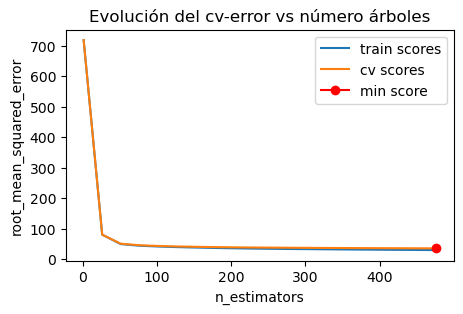

In [16]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_iter_range = range(1, 500, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
# ==============================================================================
for max_iter in max_iter_range:
    
    modelo = HistGradientBoostingRegressor(
                max_iter     = max_iter,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train_scaled, y_train)
    predicciones = modelo.predict(X = X_train_scaled)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train_scaled,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_iter_range, train_scores, label="train scores")
ax.plot(max_iter_range, cv_scores, label="cv scores")
ax.plot(max_iter_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {max_iter_range[np.argmin(cv_scores)]}")

Los valores estimados por validación cruzada muestran que, a partir de los 50 árboles, el error del modelo se estabiliza, consiguiendo un mínimo con 476 árboles.

### Learning rate
El learning_rate es el hiperparámetro más importantes en Gradient Boosting junto con el numero de arboles obtenidos anteriormente, ya que nos permite controlar cómo de rápido aprenderá nuestro modelo y con ello el riesgo de llegar al overfitting. Cuanto menor es el learning rate, más árboles se necesitan para alcanzar buenos resultados pero menor es el riesgo de overfitting.

In [17]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
resultados = {}

# Valores evaluados
learning_rates_grid = [0.001, 0.01, 0.1]
max_iter_grid   = [10, 20, 100, 200, 300, 400, 500, 1000]


# Bucle para entrenar un modelo con cada combinacion de  learning_rate y n_estimator 
# y extraer su error de entrenamiento y k-cross-validation.
for learning_rate in learning_rates_grid:
    train_scores = []
    cv_scores    = []
    
    for n_estimator in max_iter_grid:
    
        modelo = HistGradientBoostingRegressor(
                    max_iter      =  n_estimator,
                    learning_rate = learning_rate,
                    random_state  = 123
                 )

        # Error de train
        modelo.fit(X_train_scaled, y_train)
        predicciones = modelo.predict(X = X_train_scaled)
        rmse = mean_squared_error(
                y_true  = y_train,
                y_pred  = predicciones,
                squared = False
               )
        train_scores.append(rmse)

        # Error de validación cruzada
        scores = cross_val_score(
                    estimator = modelo,
                    X         = X_train_scaled,
                    y         = y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 3,
                    n_jobs    = multiprocessing.cpu_count() - 1
                 )
        # Se agregan los scores de cross_val_score() y se pasa a positivo
        cv_scores.append(-1*scores.mean())
        
    resultados[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

# Gráficando con la evolución de los errores de entrenamiento
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

for key, value in resultados.items():
    axs[0].plot(max_iter_grid, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("Evolución del train error vs learning rate")
    
    axs[1].plot(max_iter_grid, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("Evolución del cv-error vs learning rate")
    plt.legend();

c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\skle

KeyboardInterrupt: 

### Max depth
Obteniendo la profundidad de los árboles (max_depth), para lo cual el valor sera muy bajo, para que cada árbol solo pueda aprender una pequeña parte de la relación entre predictores y la variable de la demanda de energía (variable respuesta).

c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\skle

Valor óptimo de max_depth: 10


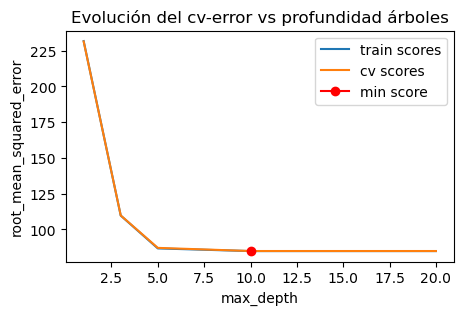

In [18]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_depths = [1, 3, 5, 10, 20]

# Bucle para entrenar un modelo con cada valor de max_depth y extraer su error
# de entrenamiento y de k-cross-validation.
for max_depth in max_depths:
    
    modelo = HistGradientBoostingRegressor(
                max_iter     = 25,
                max_depth    = max_depth,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train_scaled, y_train)
    predicciones = modelo.predict(X = X_train_scaled)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train_scaled,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolución del cv-error vs profundidad árboles")
plt.legend();
print(f"Valor óptimo de max_depth: {max_depths[np.argmin(cv_scores)]}")

Obtuvimos un valor optimo de profundidad de 10, nivel que podra alcanzar los arboles.

### Grid search
Antes pudimos hacer la busqueda individual de los valores de hiperparametros que puedan apoyar a nuestro modelo de la mejor manera, los mejores vaya. 
Ahora vamos a recurrir a recurrir a grid search para analizar varias combinaciones de hiperparametros.

En la búsqueda de hiperparámetros que se muestra a continuación, se apoyara con la estrategia de no incluir el número de árboles como hiperparámetro. a cambio de esto, se utiliza por defecto un número muy elevado (para este ejemplo el valor de 1000) y se activa la parada temprana.

In [19]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'loss'             : ['squared_error', 'absolute_error'],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'max_depth'        : [3, 5, 10, 20],
              'l2_regularization': [0, 1, 10]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = HistGradientBoostingRegressor(
                        max_iter            = 1000, 
                        random_state        = 123,
                        # Activación de la parada temprana
                        early_stopping      = True,
                        validation_fraction = 0.1,
                        n_iter_no_change    = 10,
                        tol                 = 1e-7,
                        scoring             = 'loss',
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_scaled, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_l2_regularization,param_learning_rate,param_loss,param_max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
43,1,0.1,squared_error,20,-34.598538,0.200484,-24.394770,0.461523
42,1,0.1,squared_error,10,-34.635198,0.302723,-24.463323,0.559831
18,0,0.1,squared_error,10,-34.701760,0.129900,-24.467748,0.243408
19,0,0.1,squared_error,20,-34.803970,0.352309,-24.859461,0.833079


In [20]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'l2_regularization': 1, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 20} : -34.598537611783144 neg_root_mean_squared_error


In [21]:
# Número de árboles del modelo final (early stopping)
# ==============================================================================
print(f"Número de árboles del modelo: {grid.best_estimator_.n_iter_}")

Número de árboles del modelo: 977


In [59]:
grid.best_estimator_

HistGradientBoostingRegressor(early_stopping=True, l2_regularization=1,
                              max_depth=20, max_iter=1000, random_state=123)

> En el resultado de arriba se observa los hiperparametros utilizados y sus valores optimos.

In [23]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test_scaled)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

# Cálculo del MAPE
mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predicciones)
print(f"El error (mape) de test es: {mape}")

El error (rmse) de test es: 33.31653917376986
El error (mape) de test es: 0.009566973964040217


c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Tras optimizar los hiperparámetros, se consigue reducir el error rmse del modelo de 286.15 a 33.31, algo muy siginificativo. Las predicciones del modelo final se alejan en promedio 33.31 unidades del valor real.  
El mape tambien se logro bajar significativamente de un 10.34% a un 0.95% un gran cambio.

### Importancia de predictores
Para esto usaremos el método de permutación

In [24]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train_scaled,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

Anteriormente nos muestra un error, esto porque nos equivocamos al extraer las columnas de los datos estandarizados y no de los datos de entramiento de las variables predictoras, abajo se corrige eso.
Observamos que el proceso para encontrar los mejores predictores tardo 232 min aproximadamente.

In [33]:
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
299,1156.026603,8.332415e-01,demanda_energia(t-1)
274,134.765792,1.962302e-01,demanda_energia(t-2)
149,70.930012,1.494951e-01,demanda_energia(t-7)
24,49.661222,1.790977e-01,demanda_energia(t-12)
199,32.963354,8.899922e-02,demanda_energia(t-5)
...,...,...,...
215,0.000000,0.000000e+00,martes_postfestivo(t-4)
295,0.000000,0.000000e+00,2_nov.(t-1)
296,0.000000,0.000000e+00,pre-navidad_y_new_year(t-1)
171,0.000000,0.000000e+00,pre-navidad_y_new_year(t-6)


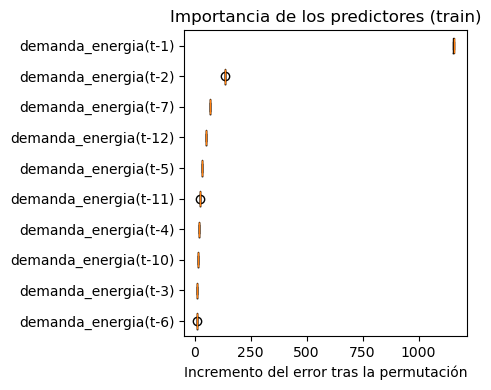

In [39]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 4))
sorted_idx = importancia.importances_mean.argsort()[-10:]
ax.boxplot(
        importancia.importances[sorted_idx].T,
        vert   = False,
        labels = X.columns[sorted_idx]
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')
fig.tight_layout();

Ambas estrategias para encontrar los mejores predictores, destacan a las variables demanda_energia(t-1), demanda_energia(t-2), demanda_energia(t-7) como los predictores mas influyentes en nuestro modelo, pero (t-1) se destaca como la unica mas influyente de todas, esto respecto a los datos de entrenamiento.

### Curva de aprendizaje

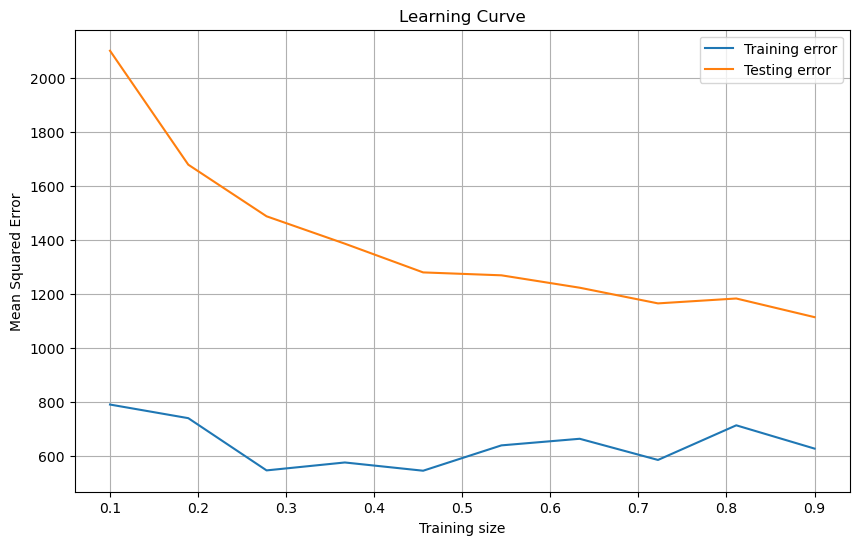

In [42]:
train_sizes = np.linspace(0.1, 0.9, 10)
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_partial, _, y_train_partial, _ = train_test_split(X_train_scaled, y_train, train_size=train_size, random_state=123)
    modelo_final.fit(X_train_partial, y_train_partial)
    train_scores.append(mean_squared_error(y_train_partial, modelo_final.predict(X_train_partial)))
    test_scores.append(mean_squared_error(y_test, modelo_final.predict(X_test_scaled)))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, label='Training error')
plt.plot(train_sizes, test_scores, label='Testing error')
plt.xlabel('Training size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

Comportamiento del error de entrenamiento (línea azul):  

* Inicialmente, el error de entrenamiento es bajo y tiende a estabilizarse a medida que aumenta el tamaño del conjunto de entrenamiento. Esto indica que el modelo está aprendiendo bien de los datos de entrenamiento.
* Un error de entrenamiento bajo sugiere que el modelo está ajustando bien los datos de entrenamiento, aunque podría estar sobreajustando (overfitting) si la brecha entre el error de entrenamiento y el error de prueba es grande.  

Comportamiento del error de prueba (línea naranja):  

* Inicialmente, el error de prueba es alto, lo que indica que el modelo no generaliza bien cuando se entrena con un conjunto de datos pequeño.
* A medida que aumenta el tamaño del conjunto de entrenamiento, el error de prueba disminuye. Esto indica que el modelo está mejorando su capacidad de generalización al aprender de más datos.
* La disminución del error de prueba se estabiliza en algún punto, lo que sugiere que añadir más datos de entrenamiento ya no mejora significativamente el rendimiento del modelo en el conjunto de prueba.  

Nuestro modelo a pesar que esta aprendiendo bien y esta teniendo buenos resultados conforme va aumenta el tamaño del conjunto de entramiento, se ve que sigue existiendo una brecha entre el error de entranamiento  y el error de prueba, observando como el error de entrenamiento es mucho menor que el de prueba, por lo que nos puede indicar un sobreajuste, sin embargo la misma grafica nos sugiere el sobre ajuste disminuye con mas datos de prueba.

Finalmente, podemos visualizar mejor las predicciones de nuestro modelo si comparamos los valores predichos contra los valores reales del dataset de prueba. Idealmente, deberiamos ver nuestro plot como una línea de pendiente 1:

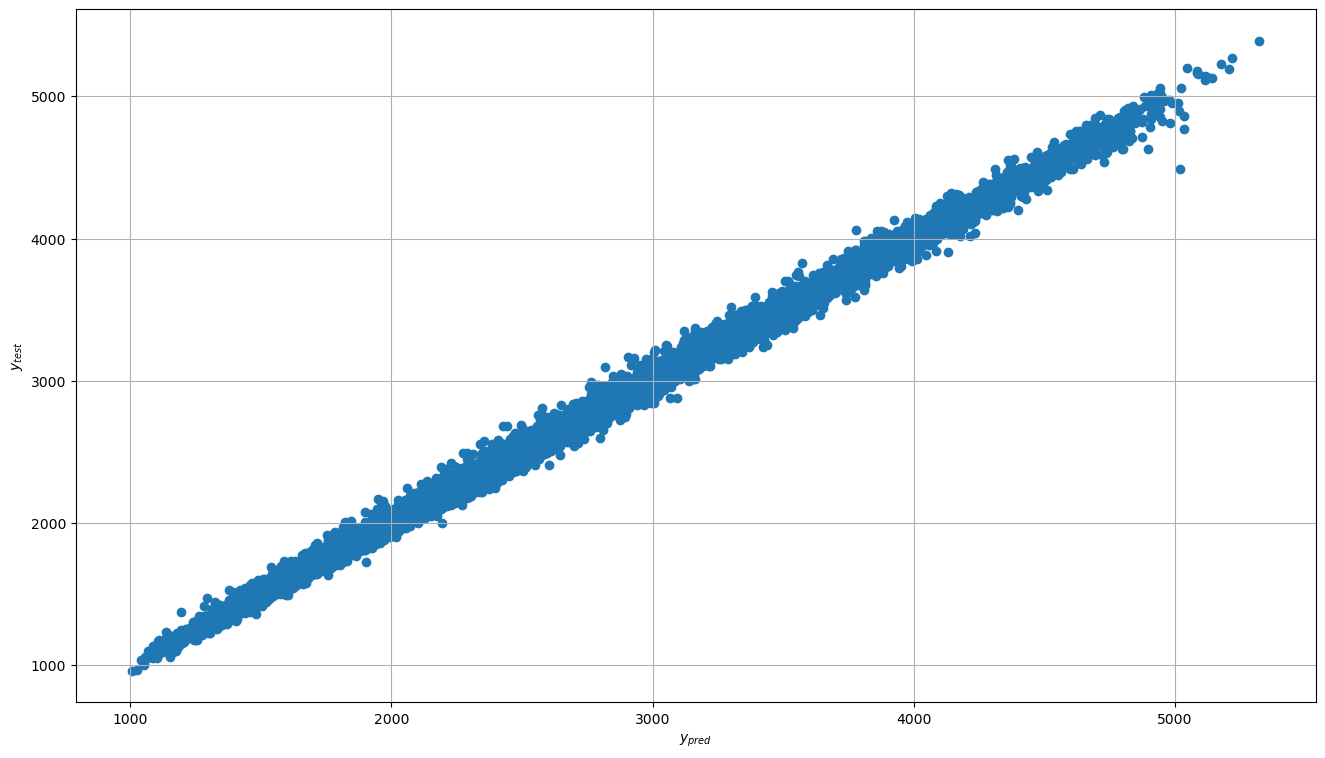

In [40]:
fig,ax = plt.subplots(figsize=(16,9))
ax.grid()
ax.scatter(predicciones, y_test)
ax.set_ylabel(r'$y_{test}$')
ax.set_xlabel(r'$y_{pred}$')
plt.show()

Con el diagrama anterior podemos apreciar que, como lo indicaron las metricas del modelo, los valores predichos son muy parecidos a los reales, ya que se puede ver de forma general, que los puntos se empalman alrededor de una linea con pendiente 1.

### Agregando y entrenando el Modelo mediante MLFLOW

In [68]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Gradient-Boosting-Model")
mlflow.sklearn.autolog()

2024/05/24 14:22:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


In [69]:
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test_scaled)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

# Cálculo del MAPE
mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predicciones)
print(f"El error (mape) de test es: {mape}")

El error (rmse) de test es: 33.37874047456491
El error (mape) de test es: 0.009618178158757523


c:\Proyectos\Maestria\AAA\Modelos\energy-demand-prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [70]:
try:
    mlflow.end_run()
except Exception as e:
    pass

In [71]:
with mlflow.start_run() as run:
    # Registrando métricas obtenidas
    mlflow.log_metric("test_mean_absolute_percentage_error", mape)
    mlflow.log_metric("test_mean_squared_error", rmse)
    
    # Registrando parámetros del modelo
    mlflow.log_param("max_iter", modelo_final.get_params()["max_iter"])
    mlflow.log_param("l2_regularization", modelo_final.get_params()["l2_regularization"])
    mlflow.log_param("max_depth", modelo_final.get_params()["max_depth"])
    mlflow.log_param("early_stopping", modelo_final.get_params()["early_stopping"])
    mlflow.log_param("loss", modelo_final.get_params()["loss"])
    
    print(f"MLflow run ID: {run.info.run_id}")

MLflow run ID: 6ca99ee636a9435fa930e577d2452ce6


### Conclusiones

Como conclusión, en esta libreta pudimos apreciar que en caso del Gradient Boosting, incluso siendo un modelo que tarda debido a la magnitud de nuestros datos y la cantidad enorme de varibales con as que contamos, genero resultados muy satisfactorios, eso si apoyandose de Grid Search para obtimizar sus hiperparametros y con ello logramos predecir muy bien nuestra variable objetivo.  Además de esto, nuestra métrica objetivo (MAPE) alcanza un valor de apenas 0.9%, lo cual indica un buen desempeño del modelo.

Lo importante es que podemos siempre comparar los resultados con otros modelos disponibles en las diversas librerías de python en este proyecto, para obtener un mejor rendimiento en un caso dado o bien confirmar si este modelo cumple con mejor desempeño o no.  Lo importante que con este modelo tenemos una opción muy viable para poder pronosticar/predecir la demanda de eneregía, cumpliendo con nuestras metricas de desempeño.